klue/roberta-small 모델 사용

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ln -s /content/drive/MyDrive/ /gdrive

In [3]:
!mkdir data

In [4]:
!cp /gdrive/aicon/aicon_retrailer/train/train.csv data/
!cp /gdrive/aicon/aicon_retrailer/test/test.csv data/
!cp /gdrive/aicon/aicon_retrailer/val/val.csv data/
!cp /gdrive/aicon/aicon_retrailer/sample_submission.csv data/

In [ ]:
!pip install transformers datasets

     |████████████████████████████████| 2.8 MB 8.0 MB/s 
     |████████████████████████████████| 264 kB 88.3 MB/s 
     |████████████████████████████████| 50 kB 8.6 MB/s 
     |████████████████████████████████| 895 kB 81.1 MB/s 
     |████████████████████████████████| 3.3 MB 59.6 MB/s 
     |████████████████████████████████| 636 kB 64.9 MB/s 
     |████████████████████████████████| 119 kB 90.0 MB/s 
     |████████████████████████████████| 243 kB 91.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
import warnings
import re

import numpy as np
import pandas as pd

import datasets
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

import seaborn as sns

#import optuna
#from ray import tune

warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
train = pd.read_csv("./data/train.csv")
valid = pd.read_csv("./data/val.csv")
test = pd.read_csv("./data/test.csv")

In [7]:
dataset = pd.concat([train, valid], join='inner')

In [8]:
map_dict = {'AS_날짜_요청': 0,'AS_날짜_질문': 1,'AS_방법_요청': 2,'AS_방법_질문': 3,'AS_비용_요청': 4,'AS_비용_질문': 5,
                        'AS_시간_질문': 6,'AS_일반_질문': 7,'결제_방식_질문': 8,'결제_수단_질문': 9,'결제_시기_질문': 10,'결제_영수증_질문': 11,
                        '결제_오류_질문': 12,'결제_일반_질문': 13,'결제_일반_확인': 14,'결제_재결제_질문': 15,'결제_추가_질문': 16,
                        '결제_취소_질문': 17,'결제_할인_질문': 18,'교환|반품|환불_방법_요청': 19,'교환|반품|환불_방법_질문': 20,
                        '교환|반품|환불_방법_확인': 21,'교환|반품|환불_비용_질문': 22,'교환|반품|환불_시간_요청': 23,
                        '교환|반품|환불_시간_질문': 24,'교환|반품|환불_일반_요청': 25,'교환|반품|환불_일반_질문': 26,
                        '교환|반품|환불_일반_확인': 27,'구매_예약_요청': 28,'구매_예약_질문': 29,'구매_제품_요청': 30,'구매_제품_질문': 31,
                        '매장_이용_요청': 32,'매장_이용_질문': 33,'매장_정보_질문': 34,'멤버십_사용_질문': 35,'멤버십_적립_질문': 36,
                        '배송_날짜_요청': 37,'배송_날짜_질문': 38,'배송_날짜_확인': 39,'배송_방법_요청': 40,'배송_방법_질문': 41,
                        '배송_방법_확인': 42,'배송_비용_질문': 43,'배송_오류_질문': 44,'배송_오류_확인': 45,'배송_일반_요청': 46,
                        '배송_일반_질문': 47,'배송_일반_확인': 48,'배송_지역_요청': 49,'배송_지역_질문': 50,'배송_택배사_질문': 51,
                        '부가서비스_날짜_요청': 52,'부가서비스_날짜_질문': 53,'부가서비스_방법_요청': 54,'부가서비스_방법_질문': 55,
                        '부가서비스_비용_요청': 56,'부가서비스_비용_질문': 57,'웹사이트_사용_질문': 58,'웹사이트_오류_질문': 59,
                        '제품_가격_비교': 60,'제품_가격_요청': 61,'제품_가격_질문': 62,'제품_가격_확인': 63,'제품_구성_요청': 64,
                        '제품_구성_질문': 65,'제품_구성_확인': 66,'제품_날짜_질문': 67,'제품_방법_요청': 68,'제품_방법_질문': 69,
                        '제품_방법_확인': 70,'제품_불량_요청': 71,'제품_불량_질문': 72,'제품_불량_확인': 73,'제품_소재_질문': 74,
                        '제품_시용_요청': 75,'제품_시용_질문': 76,'제품_용도_질문': 77,'제품_용도_확인': 78,'제품_원산지_질문': 79,
                        '제품_일반_비교': 80,'제품_일반_요청': 81,'제품_일반_질문': 82,'제품_일반_확인': 83,'제품_입고_요청': 84,
                        '제품_입고_질문': 85,'제품_재고_요청': 86,'제품_재고_질문': 87,'제품_재고_확인': 88,'제품_정보_비교': 89,
                        '제품_정보_요청': 90,'제품_정보_질문': 91,'제품_정보_확인': 92,'제품_추천_비교': 93,'제품_추천_요청': 94,
                        '제품_추천_질문': 95,'제품_추천_확인': 96,'제품_커스텀_요청': 97,'제품_커스텀_질문': 98,'제품_품질_비교': 99,
                        '제품_품질_요청': 100,'제품_품질_질문': 101,'제품_품질_확인': 102,'제품_호환_질문': 103,'제품_호환_확인': 104,
                        '포장_방식_요청': 105,'포장_방식_질문': 106,'포장_비용_질문': 107,'포장_일반_질문': 108,'행사_기간_질문': 109,
                        '행사_기간_확인': 110,'행사_날짜_질문': 111,'행사_유형_질문': 112,'행사_유형_확인': 113,'행사_일반_질문': 114,
                        '행사_일반_확인': 115,'행사_정보_요청': 116,'행사_정보_질문': 117,'minor':200,'major':300}

In [9]:
dict_map = {v : k for k, v in map_dict.items()}

dict_map

{0: 'AS_날짜_요청',
 1: 'AS_날짜_질문',
 2: 'AS_방법_요청',
 3: 'AS_방법_질문',
 4: 'AS_비용_요청',
 5: 'AS_비용_질문',
 6: 'AS_시간_질문',
 7: 'AS_일반_질문',
 8: '결제_방식_질문',
 9: '결제_수단_질문',
 10: '결제_시기_질문',
 11: '결제_영수증_질문',
 12: '결제_오류_질문',
 13: '결제_일반_질문',
 14: '결제_일반_확인',
 15: '결제_재결제_질문',
 16: '결제_추가_질문',
 17: '결제_취소_질문',
 18: '결제_할인_질문',
 19: '교환|반품|환불_방법_요청',
 20: '교환|반품|환불_방법_질문',
 21: '교환|반품|환불_방법_확인',
 22: '교환|반품|환불_비용_질문',
 23: '교환|반품|환불_시간_요청',
 24: '교환|반품|환불_시간_질문',
 25: '교환|반품|환불_일반_요청',
 26: '교환|반품|환불_일반_질문',
 27: '교환|반품|환불_일반_확인',
 28: '구매_예약_요청',
 29: '구매_예약_질문',
 30: '구매_제품_요청',
 31: '구매_제품_질문',
 32: '매장_이용_요청',
 33: '매장_이용_질문',
 34: '매장_정보_질문',
 35: '멤버십_사용_질문',
 36: '멤버십_적립_질문',
 37: '배송_날짜_요청',
 38: '배송_날짜_질문',
 39: '배송_날짜_확인',
 40: '배송_방법_요청',
 41: '배송_방법_질문',
 42: '배송_방법_확인',
 43: '배송_비용_질문',
 44: '배송_오류_질문',
 45: '배송_오류_확인',
 46: '배송_일반_요청',
 47: '배송_일반_질문',
 48: '배송_일반_확인',
 49: '배송_지역_요청',
 50: '배송_지역_질문',
 51: '배송_택배사_질문',
 52: '부가서비스_날짜_요청',
 53: '부가서비스_날짜_질문',
 54: '부가서비스_방법_요청',
 55: '부

In [10]:
def set_values(row, value):
    return value[row]

In [11]:
dataset['label'] = dataset['intent'].apply(set_values, args =(map_dict, ))

In [12]:
dataset.label.value_counts(sort = True)

91     72999
38     54908
69     28061
103    24785
65     18246
       ...  
63        71
9         70
78        70
35        66
42        60
Name: label, Length: 118, dtype: int64

In [13]:
dataset.count()

conv_num    374783
intent      374783
question    374783
answer      374783
label       374783
dtype: int64

In [14]:
dataset.head()

,conv_num,intent,question,answer,label
0,5087,AS_날짜_요청,제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.,"네, 무상 리퍼 남았는지 확인 도와드리겠습니다.",0
1,9373,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?,"네, 휴대폰 내일 받으실 수 있습니다.",0
2,9374,AS_날짜_요청,오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?,"네, 이번주 안으로 받으실 수 있습니다.",0
3,9378,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?,"죄송합니다만, 내일 받아보시는건 어렵습니다.",0
4,9379,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?,"아니요, 내일은 어렵습니다.",0


In [15]:
dataset['intent'].fillna('NAN', inplace=True)
dataset['question'].fillna('NAN', inplace=True)
dataset['answer'].fillna('NAN', inplace=True)

In [16]:
dataset['data'] = dataset['question'] + dataset['answer']
test['data'] = test['question'] + test['answer']

In [17]:
dataset.head()

,conv_num,intent,question,answer,label,data
0,5087,AS_날짜_요청,제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.,"네, 무상 리퍼 남았는지 확인 도와드리겠습니다.",0,"제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.네, 무상 리퍼 남았는지 확인..."
1,9373,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?,"네, 휴대폰 내일 받으실 수 있습니다.",0,"오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?네, 휴대폰 내일 받으실 수 있습니다."
2,9374,AS_날짜_요청,오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?,"네, 이번주 안으로 받으실 수 있습니다.",0,"오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?네, 이번주 안으로 받으실..."
3,9378,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?,"죄송합니다만, 내일 받아보시는건 어렵습니다.",0,"오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?죄송합니다만, 내일 받아보시는건 어..."
4,9379,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?,"아니요, 내일은 어렵습니다.",0,"오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?아니요, 내일은 어렵습니다."


In [18]:
test.head()

,conv_num,question,answer,data
0,9710,노트북 수리 맡기면 바로 받을 수 있나요?,오늘 바로 받으실 수 있어요.,노트북 수리 맡기면 바로 받을 수 있나요?오늘 바로 받으실 수 있어요.
1,9711,노트북 수리 맡기면 오늘 받을 수 있어요?,"네, 오늘 받으실 수 있습니다.","노트북 수리 맡기면 오늘 받을 수 있어요?네, 오늘 받으실 수 있습니다."
2,9728,오늘 노트북 수리 들어가면 내일 찾을 수 있죠?,"네, 내일 찾아가세요.","오늘 노트북 수리 들어가면 내일 찾을 수 있죠?네, 내일 찾아가세요."
3,9737,어제 수리맡긴 노트북 내일 찾을 수 있습니까?,"네, 내일 찾으러 오시면 됩니다.","어제 수리맡긴 노트북 내일 찾을 수 있습니까?네, 내일 찾으러 오시면 됩니다."
4,11050,TV AS 이번주 안에 가능한가요?,"네, 이번주까지 해드리겠습니다.","TV AS 이번주 안에 가능한가요?네, 이번주까지 해드리겠습니다."


In [19]:
dataset=dataset[['data','label']]
test=test[['data']]

In [20]:
dataset.head()

,data,label
0,"제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.네, 무상 리퍼 남았는지 확인...",0
1,"오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?네, 휴대폰 내일 받으실 수 있습니다.",0
2,"오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?네, 이번주 안으로 받으실...",0
3,"오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?죄송합니다만, 내일 받아보시는건 어...",0
4,"오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?아니요, 내일은 어렵습니다.",0


In [21]:
test.head()

,data
0,노트북 수리 맡기면 바로 받을 수 있나요?오늘 바로 받으실 수 있어요.
1,"노트북 수리 맡기면 오늘 받을 수 있어요?네, 오늘 받으실 수 있습니다."
2,"오늘 노트북 수리 들어가면 내일 찾을 수 있죠?네, 내일 찾아가세요."
3,"어제 수리맡긴 노트북 내일 찾을 수 있습니까?네, 내일 찾으러 오시면 됩니다."
4,"TV AS 이번주 안에 가능한가요?네, 이번주까지 해드리겠습니다."


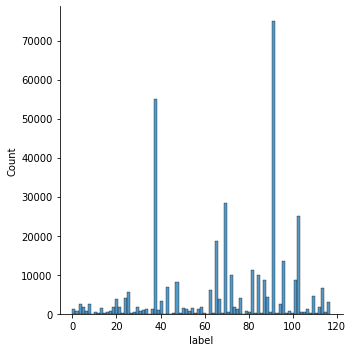

In [24]:
sns.displot(dataset.label)

In [25]:
model_checkpoint = "klue/roberta-small"
RANDOM_SEED = 42

In [26]:
major = [91, 38, 69, 103, 65]

In [27]:
data_list = []
for i in range(118):
  x = dataset['label'] == i
  y = dataset[x]
  data_list.append(y)

In [28]:
sub_major = []
sub_minor = []

In [29]:
for i in range(118):
  x = data_list[i].label.value_counts(sort = True)
  x = int(x)
  if x >= 7000 and x < 18000:
    sub_major.append(i)
    print(i, x)

47 7886
72 9996
82 11233
85 9722
87 8513
95 13395
101 8648


In [30]:
for i in range(118):
  x = data_list[i].label.value_counts(sort = True)
  x = int(x)
  if x > 4000 and x < 7000:
    sub_minor.append(i)
    print(i, x)

24 4025
26 5400
62 5993
89 4225
109 4496
114 6290


In [31]:
for i in range(118):
  x = data_list[i].label.value_counts(sort = True)
  x = int(x)
  if x <= 4000:
    print(i, x)

0 163
1 1126
2 688
3 2468
4 170
5 1673
6 730
7 2427
8 182
9 70
10 199
11 148
12 106
13 1542
14 90
15 115
16 482
17 699
18 789
19 968
20 3827
21 80
22 1654
23 208
25 218
27 122
28 585
29 477
30 1316
31 652
32 338
33 655
34 1179
35 66
36 161
37 1131
39 1022
40 539
41 2742
42 60
43 3242
44 3690
45 72
46 172
48 216
49 247
50 1393
51 849
52 398
53 734
54 355
55 1112
56 122
57 1248
58 1446
59 216
60 121
61 73
63 71
64 219
66 485
67 3838
68 151
70 288
71 508
73 152
74 1566
75 1331
76 969
77 2954
78 70
79 599
80 221
81 147
83 186
84 128
86 146
88 79
90 417
92 2001
93 121
94 2601
96 150
97 203
98 426
99 197
100 88
102 149
104 410
105 427
106 808
107 412
108 238
110 79
111 131
112 1864
113 207
115 341
116 119
117 2892


In [32]:
sub_major

[47, 72, 82, 85, 87, 95, 101]

In [33]:
sub_minor

[24, 26, 62, 89, 109, 114]

In [34]:
sampled_data_list1 = []
sampled_data_list2 = []
for i in range(118):
  if i in major:
    x = data_list[i].sample(frac=0.025, random_state=42)
    sampled_data_list1.append(x)
  elif i in sub_major:
    x = data_list[i].sample(frac=0.8, random_state=42)
    sampled_data_list1.append(x)
  elif i in sub_minor:
    x = data_list[i].sample(frac=0.9, random_state=42)
    sampled_data_list1.append(x)
  else:
    x = data_list[i]
    sampled_data_list2.append(x)

In [35]:
def sampled_dataset(sampled_data_list):
  sampled_dataset = pd.DataFrame(index=range(0, 0), columns=['data', 'label'])
  for i in range(len(sampled_data_list)):
    sampled_dataset =  pd.concat([sampled_dataset, sampled_data_list[i]], join='inner')
  return sampled_dataset

In [37]:
sampled_dataset1 = sampled_dataset(sampled_data_list1)

In [38]:
sampled_dataset2 = sampled_dataset(sampled_data_list2)

In [39]:
target = sampled_dataset1['label']
dataset_train1, dataset_val1 = train_test_split(sampled_dataset1,test_size = 0.2, stratify = target, random_state = RANDOM_SEED)

In [40]:
target = sampled_dataset2['label']
dataset_train2, dataset_val2 = train_test_split(sampled_dataset2,test_size = 0.2, stratify = target, random_state = RANDOM_SEED)

In [41]:
dataset_train1['label'] = dataset_train1['label'].apply(lambda x: 300 if x in major else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
dataset_train2['label'] = dataset_train2['label'].apply(lambda x: 300 if x in major else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
dataset_val1['label'] = dataset_val1['label'].apply(lambda x: 300 if x in major else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
dataset_val2['label'] = dataset_val2['label'].apply(lambda x: 300 if x in major else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
minor = []
for i in range(118):
  minor.append(i)
for i in major:
  minor.remove(i)

minor.append(300)

minor

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 66,
 67,
 68,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 300]

In [47]:
len(minor)

114

In [48]:
changed = []
for i in range(114):
  changed.append(i)

changed

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113]

In [49]:
len(changed)

114

In [50]:
match = {key:value for key, value in zip(changed, minor) }

match

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 39,
 39: 40,
 40: 41,
 41: 42,
 42: 43,
 43: 44,
 44: 45,
 45: 46,
 46: 47,
 47: 48,
 48: 49,
 49: 50,
 50: 51,
 51: 52,
 52: 53,
 53: 54,
 54: 55,
 55: 56,
 56: 57,
 57: 58,
 58: 59,
 59: 60,
 60: 61,
 61: 62,
 62: 63,
 63: 64,
 64: 66,
 65: 67,
 66: 68,
 67: 70,
 68: 71,
 69: 72,
 70: 73,
 71: 74,
 72: 75,
 73: 76,
 74: 77,
 75: 78,
 76: 79,
 77: 80,
 78: 81,
 79: 82,
 80: 83,
 81: 84,
 82: 85,
 83: 86,
 84: 87,
 85: 88,
 86: 89,
 87: 90,
 88: 92,
 89: 93,
 90: 94,
 91: 95,
 92: 96,
 93: 97,
 94: 98,
 95: 99,
 96: 100,
 97: 101,
 98: 102,
 99: 104,
 100: 105,
 101: 106,
 102: 107,
 103: 108,
 104: 109,
 105: 110,
 106: 111,
 107: 112,
 108: 113,
 109: 114,
 110: 

In [ ]:
#match = {0:200, 1:91, 2:38, 3:69, 4:103, 5:65}

In [51]:
for k, v in match.items():
  dataset_train1['label'] = dataset_train1['label'].apply(lambda x: k if x == v else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [52]:
for k, v in match.items():
  dataset_train2['label'] = dataset_train2['label'].apply(lambda x: k if x == v else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
for k, v in match.items():
  dataset_val1['label'] = dataset_val1['label'].apply(lambda x: k if x == v else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
for k, v in match.items():
  dataset_val2['label'] = dataset_val2['label'].apply(lambda x: k if x == v else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
ros = RandomOverSampler()
oversampled_data, oversampled_label = ros.fit_resample(dataset_train2, dataset_train2['label'])
dataset_train2 = pd.DataFrame(oversampled_data, columns=dataset_train2.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [56]:
oversampled_data, oversampled_label = ros.fit_resample(dataset_val2, dataset_val2['label'])
dataset_val2 = pd.DataFrame(oversampled_data, columns=dataset_val2.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [57]:
dataset_train = pd.concat([dataset_train1, dataset_train2], join='inner')

In [58]:
dataset_val = pd.concat([dataset_val1, dataset_val2], join='inner')

In [59]:
dataset_train.label.value_counts(sort = True)

91    8573
79    7189
69    6398
82    6222
97    5534
      ... 
77    3070
78    3070
0     3070
86    3042
24    2897
Name: label, Length: 114, dtype: int64

In [60]:
dataset_val.label.value_counts(sort = True)

91    2143
79    1797
69    1599
82    1556
97    1384
      ... 
77     768
78     768
0      768
86     760
24     725
Name: label, Length: 114, dtype: int64

In [61]:
dataset_train.label.value_counts(sort = False)

0      3070
1      3070
2      3070
3      3070
4      3070
       ... 
109    4529
110    3070
111    3070
112    3070
113    3981
Name: label, Length: 114, dtype: int64

In [62]:
dataset_val.label.value_counts(sort = False)

0       768
1       768
2       768
3       768
4       768
       ... 
109    1132
110     768
111     768
112     768
113     995
Name: label, Length: 114, dtype: int64

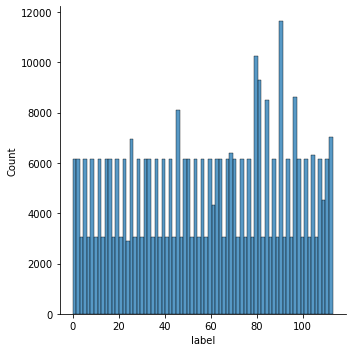

In [63]:
sns.displot(dataset_train.label)

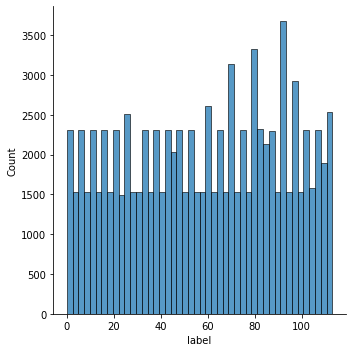

In [64]:
sns.displot(dataset_val.label)

In [65]:
dataset_train.count()

data     377300
label    377300
dtype: int64

In [66]:
dataset_val.count()

data     94375
label    94375
dtype: int64

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [ ]:
def tokenized_dataset(dataset, tokenizer):
  tokenized_sentences = tokenizer(
      list(dataset['data']),
      return_tensors="pt",
      padding=True,
      truncation=True
      )
  return tokenized_sentences

In [ ]:
# Dataset 구성.
class ROBERTA_Dataset(Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
    def get_classes(self):
        return self.labels

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')

In [ ]:
submission.head()

,conv_num,intent
0,9710,카테고리_채우기
1,9711,카테고리_채우기
2,9728,카테고리_채우기
3,9737,카테고리_채우기
4,11050,카테고리_채우기


In [ ]:
submission['label'] = submission['intent']

In [ ]:
submission.head()

,conv_num,intent,label
0,9710,카테고리_채우기,카테고리_채우기
1,9711,카테고리_채우기,카테고리_채우기
2,9728,카테고리_채우기,카테고리_채우기
3,9737,카테고리_채우기,카테고리_채우기
4,11050,카테고리_채우기,카테고리_채우기


In [ ]:
submission.loc[submission.label == '카테고리_채우기', 'label'] = 0

In [ ]:
submission.head()

,conv_num,intent,label
0,9710,카테고리_채우기,0
1,9711,카테고리_채우기,0
2,9728,카테고리_채우기,0
3,9737,카테고리_채우기,0
4,11050,카테고리_채우기,0


In [ ]:
train_label=dataset_train['label'].values
val_label=dataset_val['label'].values
test_label=submission['label'].values

tokenized_train = tokenized_dataset(dataset_train, tokenizer)
tokenized_val = tokenized_dataset(dataset_val, tokenizer)
tokenized_test = tokenized_dataset(test, tokenizer)

data_train = ROBERTA_Dataset(tokenized_train, train_label)
data_val = ROBERTA_Dataset(tokenized_val, val_label)
data_test = ROBERTA_Dataset(tokenized_test, test_label)

In [ ]:
import gc
gc.collect()

140

In [ ]:
num_labels = 114
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'cl

In [ ]:
metric = load_metric("glue", "mnli")

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    "saved",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    greater_is_better=True,
    seed = 42
)

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=data_train,
    eval_dataset=data_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

loading configuration file https://huggingface.co/klue/roberta-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6aa0817a5b48e36ec821c3d9cb8267f2dda41a32b317311688f06c742b6b2a1d.7f009d6b27d54554dce063a5fc8273742e9a198f6f627aada4bc5ea2dbbc0313
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_a

In [ ]:
trainer.train()

loading configuration file https://huggingface.co/klue/roberta-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6aa0817a5b48e36ec821c3d9cb8267f2dda41a32b317311688f06c742b6b2a1d.7f009d6b27d54554dce063a5fc8273742e9a198f6f627aada4bc5ea2dbbc0313
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_a

Epoch,Training Loss,Validation Loss


In [ ]:
trainer.evaluate()

In [ ]:
pred = trainer.predict(data_test)
pred = pred[0]
pred

In [ ]:
np.save("/gdrive/aicon/aicon_retrailer/npy/pred_classifier2_1.npy", pred)

In [ ]:
pred = np.argmax(pred,1)
submission['label'] = pred

In [ ]:
for k, v in match.items():
  submission['label'] = submission['label'].apply(lambda x: v if x == k else x)

In [ ]:
submission.label.value_counts(sort = True)

In [ ]:
submission['intent'] = submission['label'].apply(set_values, args =(dict_map, ))
submission =submission.drop('label', axis=1)
submission.head()

"\nsubmission['intent'] = submission['label'].apply(set_values, args =(dict_map, ))\nsubmission =submission.drop('label', axis=1)\nsubmission.head()\n"

In [ ]:
submission.to_csv("/gdrive/aicon/aicon_retrailer/result/klue_roberta_small_trainer_classifier2_1.csv",index=False)

In [ ]:
!cp -r ./saved/checkpoint-94326 /gdrive/aicon/aicon_retrailer/backup

참고문헌  
transformers 공식문서 How to fine-tune a model on text classification
https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb  

